# การทำความเข้าใจข้อมูลและการเตรียมข้อมูล (Data Understanding and Preprocessing)

In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer


In [2]:
#โหลดข้อมูลเครดิตจาก UCI และทำการสำรวจเบื้องต้น
# https://archive.ics.uci.edu/dataset/28/japanese+credit+screening
data_path='https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
data=pd.read_csv(data_path,names=['A'+str(i) for i in range(1,17)])


In [3]:
# ติดตั้งแพ็คเกจเพื่อให้การวิเคราะห์ข้อมูลเบื้องต้นง่ายขึ้น
# https://pub.towardsai.net/5-python-packages-for-effortless-eda-94abddac3bc5
!pip install jupyter-summarytools --quiet

## ทำความเข้าใจข้อมูล

In [4]:
from summarytools import dfSummary

In [5]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,A1[object],1. b2. a3. ?,468 (67.8%)210 (30.4%)12 (1.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABqUlEQVR4nO3bPWrDQBRF4ScjTNyMEAItZhaRxWYR2o0QmiIybpQiTsif0zi6kzc6X5fuQY5tZHyrdV0NUDjkPgD7UZnZycyOuQ/Bry7rui65j7hX3XXdYwihzX0IbkspTVVVPXkPrg4htDHGpWmac+5j8N08zw/DMLTjOB7NzHdsZmZN05z7vn/OfQxuOuU+4C/wgAAZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yNRmr7+Zyn0IflbS/6ZOKU3DMLRWyG+mSpRSmszskvuOe7FB8KGIDULFlA8q3t/ZinjF74XrdVUpq6O9cLuuKml1tBfe11U8QTvCl7qQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhlig4zbdZXHm/fO9bqqlNXRXrBBgAzrKsjwgACZrx+jfCxhM5+mfEzjsKXD25Qvxrhco/P6sIB/7n3Kd/3b3dcf8IMHBMgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBxu2UD/58nPIxjcOm2CBAhikfZF4A416W61E6oaMAAAAASUVORK5CYII="">",0(0.0%)
2,A2[object],1. ?2. 22.673. 20.424. 18.835. 24.506. 25.007. 19.178. 22.509. 20.6710. 23.5811. other,12 (1.7%)9 (1.3%)7 (1.0%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)6 (0.9%)620 (89.9%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD8UlEQVR4nO3cTW4iVwBG0QdCTjMphJC8DC+ARXixWQQL8D4sixoExxNnELrVo/zY5hKRc2YeWHqDqwKX3ufF+/v7gMLy2gfg/0NsZMRGRmxkxEZGbGTERkZsZMRGZjHGWI8x7s4/v72/v5+ueB5u2Gq32z1O07QdY4x5nl8Wi8WvguMSltM0bff7/Wm/35/O0d397W/BB6zGGGOz2byef15f8SzcOH8gkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmdUYYxyPx2/XPgi3bzXP88vhcPhxU3eM8XblM3GjbBDILPzLLCo/P9k81bioH+sqyyoubTlN0/bh4WFYVnFpyzHGWK/Xv1/7INw+L3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjILMcY43Q6/XLtg3D7lvM8vzw9PRm7cHGuhZMxeCHjyUbG4IWMwQsZgxcyXuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxrVwMgYvZPyBQOb7x+jwEcqlrXa73eMYY1hWcWnLaZq2llUUfGcjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiOzOq+qxrCs4sJcCydjXUXGk42MwQsZgxcyXn2QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjWjgZgxcynmxkDF7IGLyQ8eqDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MhYV5GxQSBjXUXGk42MdRUZ6yoyXn2QERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZExeCHjWjgZgxcynmxkDF7IGLyQ8eqDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZ18LJGLyQ8Z2NjI9RMtZVZKyryPjORkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjGvhZKyryHiykTF4IWPwQsarDzJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MgYvZFwLJ2PwQub7k82VcP6Jt898Aq52u93jeYMAf2me55fPDKNW0zRt9/v9abPZvH714bgdx+Px2+Fw2D4/P9+NMT4W2xhjbDab1/v7+9++9HTcovVnftl7NjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjKrMf68PnLtg/Df9hWNrOZ5fjkcDtvxyesj3L7zOOrDwyjXwvk3PnUt3OCFjD8QyIiNjNjIiI2M2MiIjYzYyIiNjNjI/AFAZUUsQopk2AAAAABJRU5ErkJggg=="">",0(0.0%)
3,A3[float64],Mean (sd) : 4.8 (5.0)min < med < max:0.0 < 2.8 < 28.0IQR (CV) : 6.2 (1.0),215 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACpUlEQVR4nO3dP4/aMBiA8ddwoPCntgAJNpaOlTowZu96H7Zrtw58AtZOLAgJhSBSECHQpVSVKh2HTUpe9Pzms3PDcxeTWNicz2cBqq726F8AeI+Xaz9gjGmJSNNz/sP5fN55jgX+eDNUY0xrMBi8Wmt7PpNvNpvEGPOVWBHq2n/UprW2F8fxzjm3v2XiNE2j6XTaW61WTREhVAS5eusXEXHO7YfD4U+P+VseY4B/8GEKKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUKFdx3f46soioaIWGOM7xSc/AcRKTHULMsaeZ5/Ho/H9Xq9ftNhahec/IeL0kI9HA4vURS1J5PJfjQaJbeO5+Q//K3UW7+ISKfT8T31T4ST//AbH6agAqFCBUKFCoQKFQgVKhAqVCBUqFD6c9RHMca0RKQZMAWvbyvkKUM1xrQGg8GrtbbnOwevb6vlKUMVkaa1thfH8c45d/M+A17fVk+lQw3YfWVPp1PDOZfw+vY5VDbUkN1XeZ5HRVF82u/330XEK9TALYqsb++ssqGG7L6az+e92WzWPh6PdZ9rh25RZH17f5UN9cJn91WSJEG37ZA/Eta35ah8qI8UsEWR9e2d8cAfKhAqVODWXwKeGNwfod4ZTwzKQah3xhODchBqSXyfGBRFYSXsuxBqInLyHBu07AjcCPTmtd8Vapqm0a1X3W63kYhIlmXRcrls/8/xWq+9WCw+hCwbiqJoZFn2sdvt/qjVavmt49fr9dYY801EfL6HIer3+1+cc12PsVeXPL8Ajvw9EOe90yAAAAAASUVORK5CYII="">",0(0.0%)
4,A4[object],1. u2. y

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      690 non-null    object 
 1   A2      690 non-null    object 
 2   A3      690 non-null    float64
 3   A4      690 non-null    object 
 4   A5      690 non-null    object 
 5   A6      690 non-null    object 
 6   A7      690 non-null    object 
 7   A8      690 non-null    float64
 8   A9      690 non-null    object 
 9   A10     690 non-null    object 
 10  A11     690 non-null    int64  
 11  A12     690 non-null    object 
 12  A13     690 non-null    object 
 13  A14     690 non-null    object 
 14  A15     690 non-null    int64  
 15  A16     690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


## แผนงาน

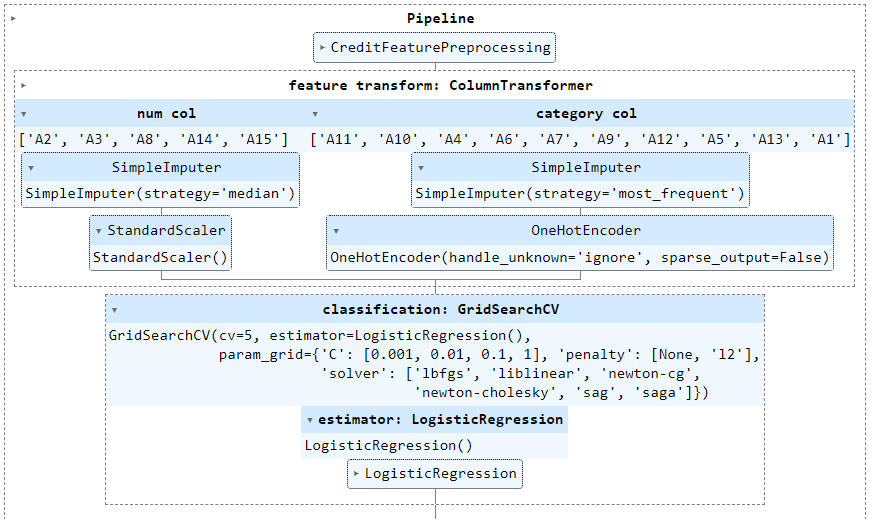

## แยกคอลัมน์ออกเป็นคอลัมน์ตัวเลข และ category

In [7]:
from sklearn.base import TransformerMixin
class CreditFeaturePreprocessing(TransformerMixin):
    def __init__(self,num_cols=[]):
        self.num_cols=num_cols

    def fit(self,X,y=None):
        return self

    def transform(self,X, y=None):
        # แทนที่ค่าที่หายไปด้วย np.nan
        X = X.replace('?', np.nan)

        # แปลงข้อมูลเป็น float
        X[self.num_cols]=X[self.num_cols].astype(float)

        return X

In [8]:
num_cols=['A2','A3','A8','A14','A15']
category_cols=list(set(data.columns)-set(num_cols+['A16']))

In [9]:
preprocessing = CreditFeaturePreprocessing(num_cols) # เตรียมตัวแปลงชนิด

## การสร้าง Pipeline สำหรับการเตรียมข้อมูลตัวเลข และ Categorical

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [11]:
# ข้อมูลตัวเลข
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')# เตรียมตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median)
z_score = StandardScaler()# เตรียมตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1
num_preprocessing=Pipeline(steps=[
    ('missing value imputer', imp_median), # นำตัวเติมค่าที่หายไปด้วยค่ามัธยฐาน (median) ใส่ใน pipeline
    ('Z-score', z_score)# นำตัวปรับค่าข้อมูลให้แต่ละคอลัมน์มีค่าเฉลี่ยเท่ากันเป็น 0 และ SD เป็น 1 ใส่ใน pipeline
])

In [12]:
# ข้อมูล category
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')# เตรียมตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode)
one_hot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')# เตรียมตัวแปลงข้อมูลเป็น One-Hot Encoding (!ชวนคิด ทำไมต้อง handle_unknown='ignore')
cat_preprocessing=Pipeline(steps=[
    ('missing value imputer', imp_mode),# นำตัวเติมค่าที่หายไปด้วยค่าฐานนิยม (mode) ใส่ใน pipeline
    ('one-hot', one_hot)# นำตัวแปลงข้อมูลแบบ One-Hot Encoding ใส่ใน pipeline
])

In [13]:
from sklearn.compose import ColumnTransformer
# สร้าง ColumnTransformer เพื่อจัดการกับการแปลงข้อมูลที่แตกต่างกัน
feature_transform = ColumnTransformer([
  ('number preprocessing', num_preprocessing, num_cols),# ใช้ pipeline num_preprocessing สำหรับคอลัมน์ตัวเลข
  ('category preprocessing', cat_preprocessing, category_cols)# ใช้ pipeline cat_preprocessing สำหรับคอลัมน์ Categorical
])
# have an pass trough

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
# กำหนด parameter grid สำหรับ GridSearchCV
param_grid = {
    'penalty': [None, 'l2'],
    'C': [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# สร้าง GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

In [15]:
# สรา้ง pipeline โดยการรวมขั้นตอนทั้งหมดไว้ที่เดียว
model=Pipeline(steps=[
    ('preprocessing', preprocessing),# preprocesing
    ('feature preprocessing', feature_transform),# data transformation
    ('classification', grid_search)# classification
])
model

Pipeline(steps=[('preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x000001A1D872B430>),
                ('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Z-score',
                                                                   StandardScaler())]),
                                                  ['A2', 'A3', 'A8', 'A14',
                                                   'A15']),
                                                 ('category preprocessing',
                                                  Pipeline(s...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['A11', 'A5', 'A7', 'A6',
                                                   'A4', 'A10', 'A13', 'A1',
                                                   'A12', 'A9'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

# ใช้งาน

In [16]:
data_path='https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
data=pd.read_csv(data_path,names=['A'+str(i) for i in range(1,17)])

In [17]:
# prompt: train validation and test split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = data.drop('A16', axis=1)
y = data['A16'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# prompt: turn off warning
import warnings
warnings.filterwarnings('ignore')

In [19]:
# train
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 <__main__.CreditFeaturePreprocessing object at 0x000001A1D872B430>),
                ('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'value '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Z-score',
                                                                   StandardScaler())]),
                                                  ['A2', 'A3', 'A8', 'A14',
                                                   'A15']),
                                                 ('category preprocessing',
                                                  Pipeline(s...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['A11', 'A5', 'A7', 'A6',
                                                   'A4', 'A10', 'A13', 'A1',
                                                   'A12', 'A9'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

In [20]:
y_pred = model.predict(X_test)

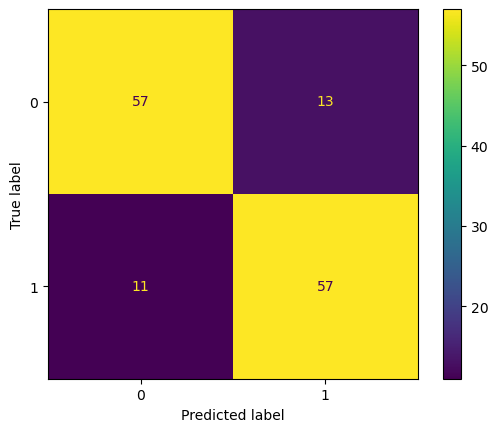

In [21]:
# prompt: compute confusion matrix and show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()


In [22]:
# prompt: print performance, precision recall f1 acc

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.81      0.83        70
           1       0.81      0.84      0.83        68

    accuracy                           0.83       138
   macro avg       0.83      0.83      0.83       138
weighted avg       0.83      0.83      0.83       138



# Workshop 03 Hands On

สร้าง prediction model โดยใช้ข้อมูลที่กำหนดให้นี้

https://github.com/praisan/hello-world/raw/master/german_credit_data.csv

In [23]:
import pandas as pd
df = pd.read_csv('https://github.com/praisan/hello-world/raw/master/german_credit_data.csv', index_col='Unnamed: 0')
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


In [24]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Age[int64],Mean (sd) : 35.5 (11.4)min < med < max:19.0 < 33.0 < 75.0IQR (CV) : 15.0 (3.1),53 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoElEQVR4nO3cMY7aQBSA4TdhIQYiG0QEHS1FpBSUHCKHzRGCxAEQN6BDMsgIBwdjSJUiCsuCx5PMc/6vH7C0v4xnvDPmer0K4Lt3//oCgEe8uPxwY0xbRFoWH3G6Xq/Hqq4HejkL1RjTHgwGX8Iw7Jf9jP1+vzPGfCVWuLyjtsIw7M9ms2MURdmzg5MkCRaLRT+O45aIEOp/zulPv4hIFEXZcDj8XnJ4u9KLgVpMpqACoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgXnW1FsFEXRFJHQGFNmODtYa8TbUNM0beZ5/nk8HjcajcbTmwPZwVov3oZ6Op1egiDoTKfTbDQa7Z4Zyw7W+vE21F+63W7ZXazsYK0RJlNQgVChgvc//WVZrhiIsGrglTdDtTjoLLxcLs0S46zZrhiIsGrgm7uh2hx0lud5UBTFpyzLvolI2SN9SrFZMRBh1cBHb91RSx90tl6v+6vVqnM+nxsW12fFYsVAhFUDrzz0jFrmoLPdbscfGpVh1g8VCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVKjt/6PaYgesXwj1BnbA+odQb2AHrH8I9Q52wPqDyRRU4I7qABOx6hFqxZiIuUGoFWMi5gahOsJErFpMpqACoUIFQoUKPKN6hjOzbiNUj3Bm1usI1SOcmfU6QvUQZ2b9iVBrpq6vbwm1Rur8+pZQa8T29e18Ph/GcfzRGLMvewmuIifUGirzjOv7igOhQkT8X3EgVPzGZsWhKIpQHE3kCBWVcD2ReyjUJEmCZ7/4cDgEIiJpmgabzabzN8dr/W6t1y0ist1uPwRB0JlMJqbX6/14ZuzxeHy/XC7vPjb8BNLGyIcxFrFGAAAAAElFTkSuQmCC"">",0(0.0%)
2,Sex[object],1. male2. female,690 (69.0%)310 (31.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABPElEQVR4nO3bQWrDMBRF0a9iQjORMAYvxovoYrsI7cYYa5CETJRBx21KAk98654VfMhNIMYv1FoNUAhmdjazU+tD8C/3Wuu19RGvGqZp+ooxjq0PwXOllC2E8O01uCHGOC7Lck0p3Vofg9/t+/6Zcx7XdT2Zmc/YzMxSSrd5ni+tj8FT59YHvOOj9QHoB7FBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTKD2c+Lea0Pwd+O8BkNpZQt5zya8xfzelBK2czs3vqOVzF48cX14CUw5YPKEX7ZXH/be+J+yud93tYT11O+I8zbenKEKR//op3goS5kiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskHE95fN6d6/cT/m8z9t6wuAFMg8KW2rft2WGMwAAAABJRU5ErkJggg=="">",0(0.0%)
3,Job[int64],Mean (sd) : 1.9 (0.7)min < med < max:0.0 < 2.0 < 3.0IQR (CV) : 0.0 (2.9),4 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABy0lEQVR4nO3dPW6DQBCG4ZnIIqZZhJz4GD6AD5HD5hBuOQmKliI4kWxcp8GYn5hv9T79oileIY1AWu+6zoC1e3n2AMAQm2cPgL/cPTezbMIjfruua+eaZy0IdUXcPd/tdh8hhHLsM5qm+XL3z9RiJdR1yUII5fF4bIuiOD96OMa4PZ1OZV3XmZkRKpZVFMV5v99/jzyezzrMSrBMQQKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQgKhQkKyV0xyS3NakgyVW5rTk2Soxi3NyUk1VDPjluaUsExBQtJvVPyviQts7/JKqJjF1AX23vJKqJjL6AV2yPJKqJjVhAW2d3llmYIEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoUEQoWEu59Ql/wjBhiqN9Sl/4gBhrr3Rs1CCOXhcLA8z38eeXDbtq9VVb3Xdf3m7s2EGccI1+t1E2PcjjkcY9xeLpeNmQV3n3m0Xqpzm02YfciZG5rjk2tLcgovAAAAAElFTkSuQmCC"">",0(0.0%)
4,Housing[object],1. own2. rent3. free,713 (71.3%)179 (17.9%)108 (10.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmElEQVR4nO3bwWnjYBSF0adgwmQjYQwuxkVMsSlC3ZhgLZKQjWaRAiKPxf35yTkVPPAXGwXdYV3XgoSn1gfwewxV9VJVz60P4b98rev60fqIrQ6n0+nvOI7H1odwv2VZ3oZheO0luMM4jsfL5fIxTdNn62PY7na7/Znn+Xi9Xp+rqo/Yqqqmafo8n8/vrY/hbi+tD7iHBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxByqvt+Nan0I9+nxMzssy/I2z/OxOns3iu83davqq/UdW9kg9K2rDcJgykdKi2+2rv4a2U98XdXbIoj9RNdVPS6C2E+LdZWn3l/KP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixERNdV/W4CGI/8XVVb4sg9mODQIx1FTEeEIjZ62fUTyM/2mXKZ57HFg9P+czz2GqvKZ95Hj/ygECM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNmIenfOZ5bLXLlM88jy1sEIgx5SPmH77xo0pg4YY6AAAAAElFTkSuQmCC"">",0(0.0%)
5,Saving accounts[object],1. little2. nan3. moderate4. quite rich5. rich,603 (60.3%)183 (18.3%)103 (10.3%)63 (6.3%)48 (4.8%),"<img src =

In [53]:
df['Checking account'].value_counts()

Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64

In [41]:
num_cols = ['Age', 'Job', 'Credit amount', 'Duration']
cat_cols = list(set(df.columns)-set(num_cols+['Risk']))

In [54]:
num_preprocessing = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_preprocessing = Pipeline(steps=[
    ('missing values imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [55]:
feature_transform = ColumnTransformer([
    ('number preprocessing', num_preprocessing, num_cols),
    ('category preprocessing', cat_preprocessing, cat_cols)
])

In [56]:
param_grid = {
    'penalty': [None, 'l2'],
    'C': [0.001, 0.01, 0.1, 1],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# สร้าง GridSearchCV object
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)

In [57]:
# สรา้ง pipeline โดยการรวมขั้นตอนทั้งหมดไว้ที่เดียว
model=Pipeline(steps=[
    ('feature preprocessing', feature_transform),# data transformation
    ('classification', grid_search)# classification
])
model

Pipeline(steps=[('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('category preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'values '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Housing', 'Saving accounts',
                                                   'Purpose', 'Sex',
                                                   'Checking account'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

In [58]:
X = df.drop('Risk', axis=1)
y = df['Risk'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# train
model.fit(X_train, y_train)

Pipeline(steps=[('feature preprocessing',
                 ColumnTransformer(transformers=[('number preprocessing',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Job',
                                                   'Credit amount',
                                                   'Duration']),
                                                 ('category preprocessing',
                                                  Pipeline(steps=[('missing '
                                                                   'values '
                                                                   'imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Housing', 'Saving accounts',
                                                   'Purpose', 'Sex',
                                                   'Checking account'])])),
                ('classification',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': [0.001, 0.01, 0.1, 1],
                                          'penalty': [None, 'l2'],
                                          'solver': ['lbfgs', 'liblinear',
                                                     'newton-cg',
                                                     'newton-cholesky', 'sag',
                                                     'saga']}))])

In [67]:
model.steps[1][1].best_params_

{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

              precision    recall  f1-score   support

           0       0.48      0.22      0.30        59
           1       0.73      0.90      0.81       141

    accuracy                           0.70       200
   macro avg       0.61      0.56      0.56       200
weighted avg       0.66      0.70      0.66       200



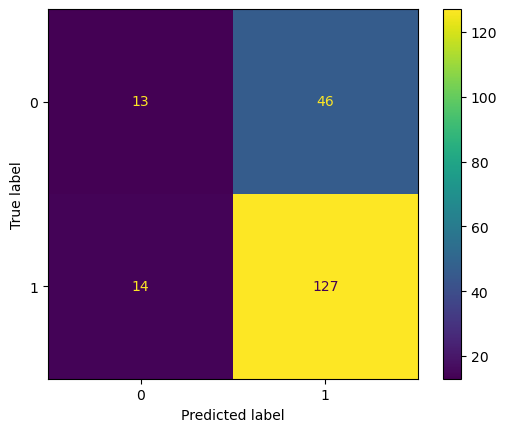

In [61]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
print(classification_report(y_test, y_pred))